loss: 1.097692311981749
dW 8.723415869868467e-12
dW -3.830069855020879e-11
dW 1.2322019446453503e-10
dW 1.1003671671755422e-10
dW 7.711999523143595e-12
dW -3.5133309564568116e-11
dW -2.8948661156202263e-11
dW 7.061439540739789e-12
dW 6.430801377521611e-11
dW 5.917015141743143e-12
dW 9.848993842709319e-11
dW -4.290943989015972e-11
dW -1.0695731193083313e-11
dW 3.692306226391051e-11
dW -4.735172073983495e-11
dW -8.97872245303466e-11
db -4.552930948920064e-12
db 3.127373143438361e-12
db 6.62211049884398e-11
db 1.2985418296196372e-10
db 6.01510601310612e-11
db -7.065829258495748e-11
db -3.35180164907098e-11
db -9.067532965797986e-11
dW -1.0781230769252304e-10
dW 4.3535055551865987e-11
dW 6.427724325019923e-11
dW -1.2491780179701983e-11
dW 1.0600807818367253e-10
dW -2.045385961296775e-10
dW 3.151864359784984e-11
dW -1.6409326490923054e-10
dW 2.1552324161455694e-11
dW 2.0122960416035784e-10
dW -6.808982089094584e-12
dW -8.339832643922129e-11
dW 6.473720517985448e-11
dW -4.1535299776396944e-1

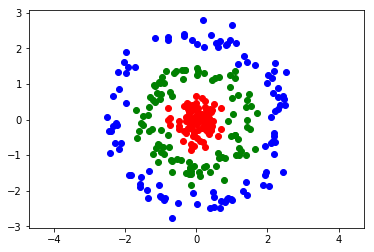

In [33]:
# https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function

import numpy as np
import matplotlib.pyplot as plt


class NeuralNetwork:
    def __init__(self, layers, relu_alpha=0.01, std=0.1):
        self.layers = layers
        self.relu_alpha = relu_alpha
        self.W = [None] * (len(layers) - 1)
        self.dW = [None] * (len(layers) - 1)
        self.b = [None] * (len(layers) - 1)
        self.db = [None] * (len(layers) - 1)
        self.z = [None] * len(layers)
        self.a = [None] * len(layers)
        
        for i in range(1, len(layers)):
            self.W[i - 1] = np.random.randn(layers[i - 1], layers[i]) * std
            self.b[i - 1] = np.random.randn(1, layers[i]) * std

        
    def forward(self, X):
        self.a[0] = X
        
        for i in range(len(self.W)):
            self.z[i + 1] = self.a[i].dot(self.W[i]) + self.b[i]
            
            if i == len(self.W) - 1:
                self.probs = np.e**self.z[i + 1]
                self.probs = self.probs / np.sum(self.probs, axis=1, keepdims=True)
                return self.probs
            
            self.a[i + 1] = self.z[i + 1].copy()
            self.a[i + 1][self.a[i + 1] < 0] *= self.relu_alpha
    
    
    def backward(self, y):
        dz = (self.probs - y) / len(y)
        
        for i in reversed(range(len(self.W))):
            self.dW[i] = self.a[i].T.dot(dz)
            self.db[i] = dz.sum(axis=0, keepdims=True)
            
            if i == 0:
                break

            da = dz.dot(self.W[i].T)
            dz = da
            dz[self.z[i] < 0] *= self.relu_alpha
        
        
    def step(self, lr):
        for i in range(len(self.W)):
            self.W[i] -= self.dW[i] * lr
            self.b[i] -= self.db[i] * lr


    def check_gradient(self, X, y):
        h = 10**-6
        threshold = 10**-6
        
        for k in range(len(self.W)):
            for i in range(self.W[k].shape[0]):
                for j in range(self.W[k].shape[1]):
                    old = self.W[k][i, j]
                    self.W[k][i, j] = old - h
                    probs = self.forward(X)
                    loss1 = -np.log((probs * y).sum(axis=1)).mean()
                    
                    self.W[k][i, j] = old + h
                    probs = self.forward(X)
                    loss2 = -np.log((probs * y).sum(axis=1)).mean()
                    
                    grad = (loss2 - loss1) / (2 * h)
                    print(f'dW {grad - self.dW[k][i, j]}')
                    self.W[k][i, j] = old
            
            for j in range(self.b[k].shape[1]):
                old = self.b[k][0, j]
                self.b[k][0, j] = old - h
                probs = self.forward(X)
                loss1 = -np.log((probs * y).sum(axis=1)).mean()

                self.b[k][0, j] = old + h
                probs = self.forward(X)
                loss2 = -np.log((probs * y).sum(axis=1)).mean()

                grad = (loss2 - loss1) / (2 * h)
                print(f'db {grad - self.db[k][0, j]}')
                self.b[k][0, j] = old


D = 2 # Input dimension
K = 3 # Number of classes
KN = 100 # Number of instances per class
N = K * KN # Total number of instances

X = np.zeros((N, D))
y = np.zeros((N, K))

for i in range(K):
    angle = np.random.uniform(0, 2 * np.pi, (KN,))
    noise = np.random.randn(KN) * 0.2
    X[i*KN:(i+1)*KN, 0] = np.cos(angle) * (i + 0.4 + noise)
    X[i*KN:(i+1)*KN, 1] = np.sin(angle) * (i + 0.4 + noise)
    y[i*KN:(i+1)*KN, i] = 1
    
plt.axes().set_aspect('equal', 'datalim')
plt.plot(X[:KN, 0], X[:KN, 1], 'ro')
plt.plot(X[KN:2*KN, 0], X[KN:2*KN, 1], 'go')
plt.plot(X[2*KN:, 0], X[2*KN:, 1], 'bo')

nn = NeuralNetwork([2, 8, 3])

for epoch in range(100):
    probs = nn.forward(X)
    loss = -np.log((probs * y).sum(axis=1)).mean()
    print(f'loss: {loss}')
    nn.backward(y)
#     nn.check_gradient(X, y)
    nn.step(0.5)